In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
# import matplotlib
# matplotlib.use("Agg")
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack
# import fitsio

from astropy import units as u
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.stats import binned_statistic

from dust_extinction.parameter_averages import F99

sys.path.append('/Users/rongpu/git/Python/user_modules/')
from user_common import extrap1d

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
r_v = 3.1
ebv = 0.03 # there is a slight dependence of r_b on the E(B-V) value

bands = ['decam_g', 'decam_r', 'decam_z']
filenames = ['decam.g.am1p4.dat.txt', 'decam.r.am1p4.dat.txt', 'decam.z.am1p4.dat.txt']

In [4]:
# Stellar spectrum
# In flux unit
sy_star = np.loadtxt('/Users/rongpu/git/LSST-Testbed/Others/extinction/Munari 7000K spectrum/T07000G45M10V000K1AODNVD01F.ASC')
sx_star = np.linspace(2500.5, 10499.5, 8000)

# Smoothing
smooth_sy_star, binned_x_edges, _ = binned_statistic(sx_star, sy_star, statistic='mean', bins=len(sx_star)//20)
smooth_sx_star = (binned_x_edges[:-1]+binned_x_edges[1:])/2
f_norm = smooth_sy_star[np.argmin(np.abs(smooth_sx_star-5500))]
smooth_sy_star = smooth_sy_star/f_norm

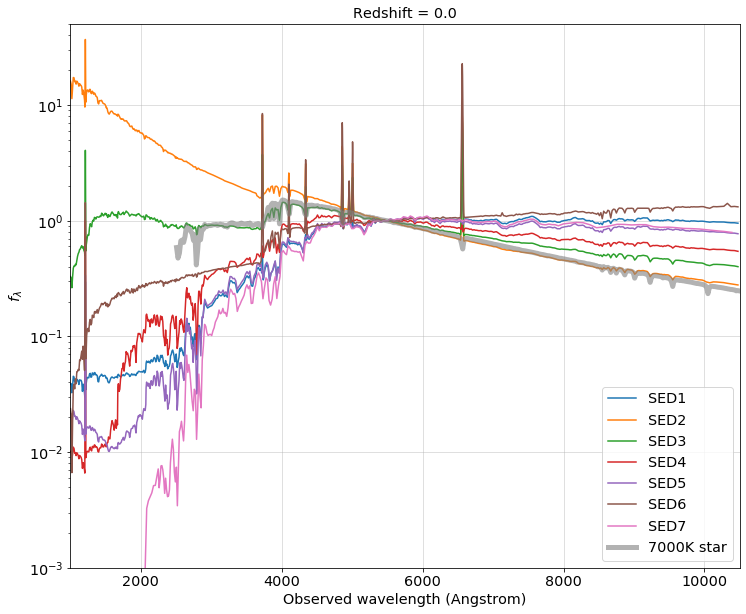

In [5]:
redshift = 0.

plt.figure(figsize=(12, 10))
for sed_index in range(1, 8):
    
    # Galaxy spectrum f_lambda (in flux unit)
    fn = '/Users/rongpu/git/desi-misc/extinction/templates/EAZY_v1.1_lines/eazy_v1.1_sed{}.dat'.format(sed_index)
    # fn = '/Users/rongpu/git/desi-misc/extinction/templates/BR07/default_sed{}.dat'.format(sed_index)
    if os.path.isfile(fn):
        tmp = Table.read(fn, format='ascii')
    else:
        break
    sx, sy = tmp['col1'], tmp['col2']
    # redshifting
    sx *= (1+redshift)
    
    f_norm = sy[np.argmin(np.abs(sx-5500))]
    sy = sy/f_norm
    mask = (sx>1000) & (sx<10500)
    plt.plot(sx[mask], sy[mask], label='SED{}'.format(sed_index))

plt.plot(smooth_sx_star, smooth_sy_star, 'gray', linewidth=5, alpha=0.6, label='7000K star')
plt.title('Redshift = {:.1f}'.format(redshift))
plt.xlabel('Observed wavelength (Angstrom)')
plt.ylabel('$f_\lambda$')

plt.xlim(1000, 10500)
plt.ylim(1e-3, 5e1)
plt.yscale('log')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

__A few different redshifts__

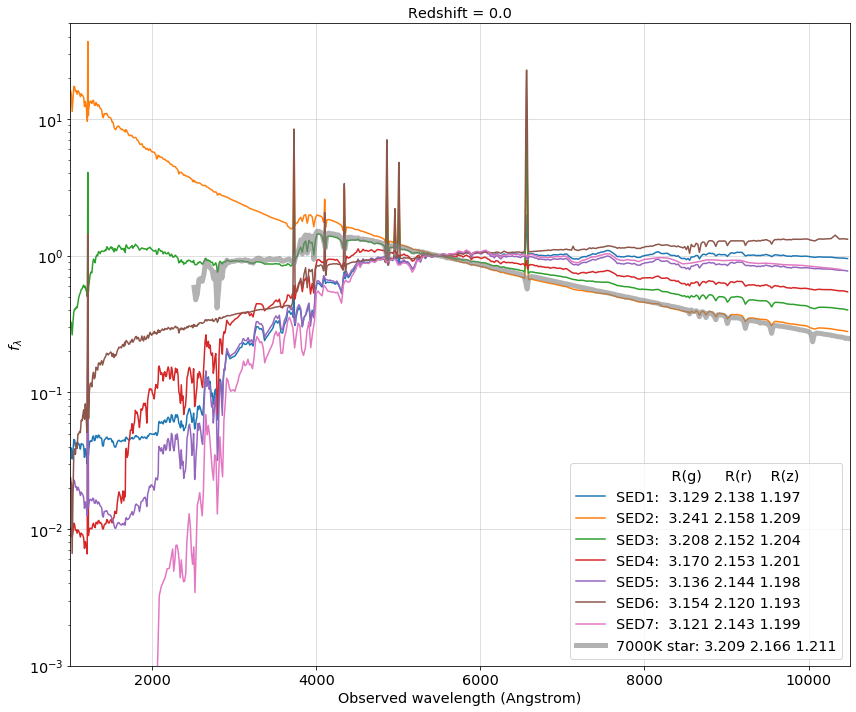

In [6]:
redshift = 0.

plt.figure(figsize=(12, 10))
plt.plot([], [], ' ', color='k', label="            R(g)     R(r)    R(z)")
for sed_index in range(1, 8):
    
    # Galaxy spectrum f_lambda (in flux unit)
    fn = '/Users/rongpu/git/desi-misc/extinction/templates/EAZY_v1.1_lines/eazy_v1.1_sed{}.dat'.format(sed_index)
    # fn = '/Users/rongpu/git/desi-misc/extinction/templates/BR07/default_sed{}.dat'.format(sed_index)
    if os.path.isfile(fn):
        tmp = Table.read(fn, format='ascii')
    else:
        break
    sx, sy = tmp['col1'], tmp['col2']
    # Convert to photon unit
    sy1 = sy * sx
    # redshifting
    sx *= (1+redshift)
    # Interpolate stellar spectrum
    s_interp = extrap1d(sx, sy1)

    r_b = np.zeros(len(bands))

    f_norm = sy[np.argmin(np.abs(sx-5500))]
    sy = sy/f_norm
    mask = (sx>1000) & (sx<10500)
    
    ######################## Compute the extinction coefficients ########################
    for index in range(len(bands)):

        band = bands[index]
        # Load filter response curve
        filename = filenames[index]
        tmp = Table.read('/Users/rongpu/git/desi-misc/extinction/filter_curves/'+filename, format='ascii')
        wx = tmp['col1']
        if 'decam' or 'mosaic' in band:
            wy = tmp['col2']
        else:
            wy = tmp['col4']
        # Interpolate filter response curve
        w_interp = extrap1d(wx, wy)

        # Integral in the denominator
        xx = np.linspace(wx.min(), wx.max(), 20000)
        wyy = w_interp(xx)
        syy = s_interp(xx)
        ws = wyy * syy
        ws_interp = extrap1d(xx, ws)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            denominator = quad(ws_interp, xx.min(), xx.max())[0]

        ext = F99(Rv=r_v)

        # extinction at 1um from O'Donnell 94
        a_1um_od94 = ebv*1.319
        # extinction at 1um from Fitzpatrick 99
        a_1um_f99 = -2.5*np.log10(ext.extinguish(np.array([10000])*u.angstrom, Ebv=ebv))

        # Integral in the numerator
        a_lambda = -2.5*np.log10(ext.extinguish(xx*u.angstrom, Ebv=ebv))/a_1um_f99
        f = wyy*syy*10.**(-a_lambda*0.78*a_1um_od94/2.5)
        f_interp = extrap1d(xx, f)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            numerator = quad(f_interp, xx.min(), xx.max())[0]

        r_b[index] = -2.5*np.log10(numerator/denominator)/ebv

    plt.plot(sx[mask], sy[mask], 
             label='SED{}:  {}'.format(sed_index, ' '.join(['{:.3f}'.format(r_b[ii]) for ii in range(len(r_b))])))

r_b_star = [3.20943905, 2.16570509, 1.21064852]
plt.plot(smooth_sx_star, smooth_sy_star, 'gray', linewidth=5, alpha=0.6, label='7000K star: '+' '.join(['{:.3f}'.format(r_b_star[ii]) for ii in range(len(r_b_star))]))
plt.title('Redshift = {:.1f}'.format(redshift))
plt.xlabel('Observed wavelength (Angstrom)')
plt.ylabel('$f_\lambda$')

plt.xlim(1000, 10500)
plt.ylim(1e-3, 5e1)
plt.yscale('log')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('plots/EAZY_v1.1_lines_z{:.1f}.png'.format(redshift))
plt.show()

In [8]:
for redshift in np.linspace(0., 1.5, 16):
    
    print(redshift)

    plt.figure(figsize=(12, 10))
    plt.plot([], [], ' ', color='k', label="            R(g)     R(r)    R(z)")
    for sed_index in range(1, 8):

        # Galaxy spectrum f_lambda (in flux unit)
        fn = '/Users/rongpu/git/desi-misc/extinction/templates/EAZY_v1.1_lines/eazy_v1.1_sed{}.dat'.format(sed_index)
        # fn = '/Users/rongpu/git/desi-misc/extinction/templates/BR07/default_sed{}.dat'.format(sed_index)
        if os.path.isfile(fn):
            tmp = Table.read(fn, format='ascii')
        else:
            break
        sx, sy = tmp['col1'], tmp['col2']
        # Convert to photon unit
        sy1 = sy * sx
        # redshifting
        sx *= (1+redshift)
        # Interpolate stellar spectrum
        s_interp = extrap1d(sx, sy1)

        r_b = np.zeros(len(bands))

        f_norm = sy[np.argmin(np.abs(sx-5500))]
        sy = sy/f_norm
        mask = (sx>1000) & (sx<10500)

        ######################## Compute the extinction coefficients ########################
        for index in range(len(bands)):

            band = bands[index]
            # Load filter response curve
            filename = filenames[index]
            tmp = Table.read('/Users/rongpu/git/desi-misc/extinction/filter_curves/'+filename, format='ascii')
            wx = tmp['col1']
            if 'decam' or 'mosaic' in band:
                wy = tmp['col2']
            else:
                wy = tmp['col4']
            # Interpolate filter response curve
            w_interp = extrap1d(wx, wy)

            # Integral in the denominator
            xx = np.linspace(wx.min(), wx.max(), 20000)
            wyy = w_interp(xx)
            syy = s_interp(xx)
            ws = wyy * syy
            ws_interp = extrap1d(xx, ws)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                denominator = quad(ws_interp, xx.min(), xx.max())[0]

            ext = F99(Rv=r_v)

            # extinction at 1um from O'Donnell 94
            a_1um_od94 = ebv*1.319
            # extinction at 1um from Fitzpatrick 99
            a_1um_f99 = -2.5*np.log10(ext.extinguish(np.array([10000])*u.angstrom, Ebv=ebv))

            # Integral in the numerator
            a_lambda = -2.5*np.log10(ext.extinguish(xx*u.angstrom, Ebv=ebv))/a_1um_f99
            f = wyy*syy*10.**(-a_lambda*0.78*a_1um_od94/2.5)
            f_interp = extrap1d(xx, f)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                numerator = quad(f_interp, xx.min(), xx.max())[0]

            r_b[index] = -2.5*np.log10(numerator/denominator)/ebv

        plt.plot(sx[mask], sy[mask], 
                 label='SED{}:  {}'.format(sed_index, ' '.join(['{:.3f}'.format(r_b[ii]) for ii in range(len(r_b))])))

    r_b_star = [3.20943905, 2.16570509, 1.21064852]
    plt.plot(smooth_sx_star, smooth_sy_star, 'gray', linewidth=5, alpha=0.6, label='7000K star: '+' '.join(['{:.3f}'.format(r_b_star[ii]) for ii in range(len(r_b_star))]))
    plt.title('Redshift = {:.1f}'.format(redshift))
    plt.xlabel('Observed wavelength (Angstrom)')
    plt.ylabel('$f_\lambda$')

    plt.xlim(1000, 10500)
    plt.ylim(1e-3, 5e1)
    plt.yscale('log')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.savefig('plots/EAZY_v1.1_lines_z{:.1f}.png'.format(redshift))
    plt.close()

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
